In [1]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
accrual_basis_payments = pd.read_csv('../files/accrual_basis_payments.csv', encoding='utf-8', sep=';')
cash_flow_payments = pd.read_csv('../files/cash_flow_payments.csv', encoding='utf-8', sep=';')

users_subscriptions = pd.read_csv('../files/users_subscriptions.csv', encoding='utf-8', sep=';')
dim_calendar = pd.read_csv('../files/dim_calendar.csv', encoding='utf-8')

# What is the total revenue generated by the app over the past one month?

### Cash Flow revenue
Here we see the revenue data from a cash flow perspective, that is, for the yearly subscriptions, all subscription value is set on the subscription_start_at date.

In [3]:
qry = """
    SELECT 
        LEFT(payment_date, 7) AS payment_month
        , subscription_type
        , SUM(payment_value) AS revenue
    FROM
        cash_flow_payments
    GROUP BY
        LEFT(payment_date, 7)
        , subscription_type
"""

cashflow_monthly_revenue_data = duckdb.query(qry).df()
cashflow_monthly_revenue_data = cashflow_monthly_revenue_data.sort_values('payment_month', ascending=True)


cashflow_monthly_revenue_data.tail()

,payment_month,subscription_type,revenue
16,2023-10,Monthly,14335.63
10,2023-11,Monthly,12529.43
39,2023-11,Yearly,19675.32
36,2023-12,Yearly,6269.20
21,2023-12,Monthly,5937.37


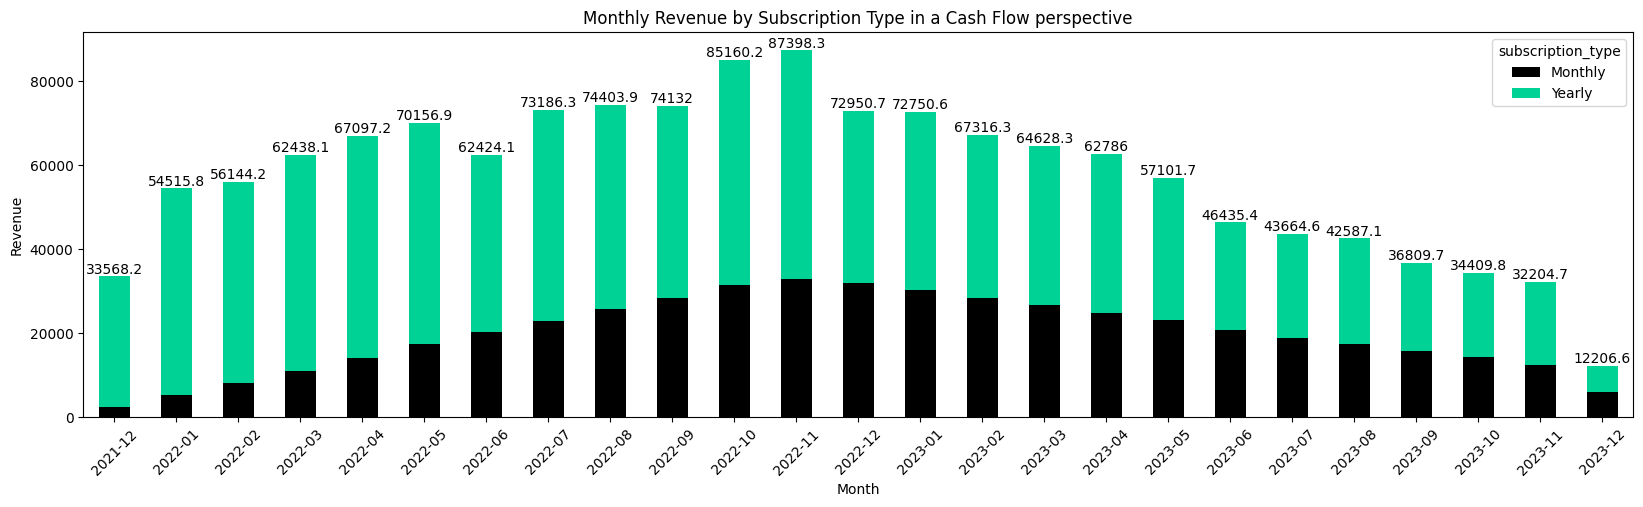

In [4]:
pivot_df = cashflow_monthly_revenue_data.pivot_table(values='revenue', index='payment_month', columns='subscription_type', aggfunc='sum')


ax = pivot_df.plot(kind='bar', 
                   stacked=True, 
                   color=['#000000', '#00D296'])


container = ax.containers[1]
ax.bar_label(container, label_type='edge', color='black')

ax.figure.set_size_inches(20, 5)
plt.title('Monthly Revenue by Subscription Type in a Cash Flow perspective')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)

plt.show()

### Revenue by accrual basis
Here we look at revenue data on an accrual basis, that is, for annual subscriptions, the subscription value is recognized as the customer uses the application, and it stops when the subscription has been canceled

In [5]:
qry = """
    SELECT 
        LEFT(payment_date, 7) AS payment_month
        , subscription_type
        , SUM(payment_value) AS revenue
    FROM
        accrual_basis_payments
    GROUP BY
        LEFT(payment_date, 7)
        , subscription_type
"""

monthly_revenue_data = duckdb.query(qry).df()
monthly_revenue_data = monthly_revenue_data.sort_values('payment_month', ascending=True)


monthly_revenue_data.tail()

,payment_month,subscription_type,revenue
27,2023-10,Monthly,14335.630000
35,2023-11,Yearly,16749.390000
31,2023-11,Monthly,12529.430000
29,2023-12,Monthly,5937.370000
42,2023-12,Yearly,8313.456667


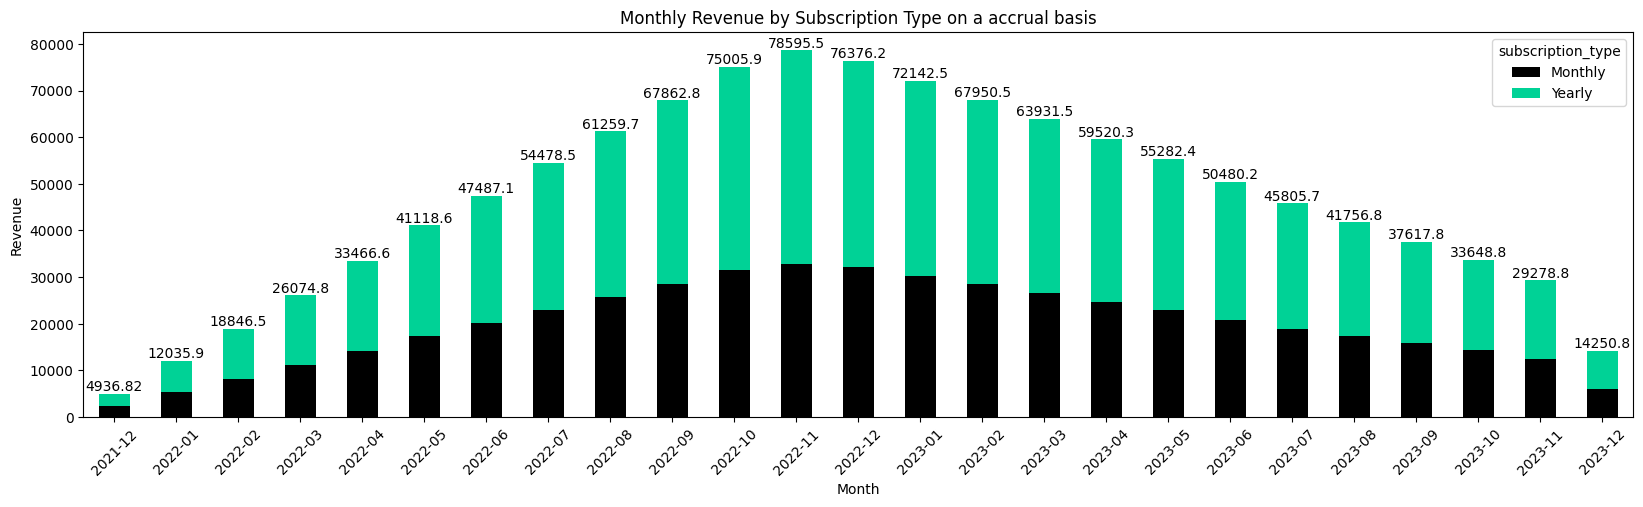

In [6]:
pivot_df = monthly_revenue_data.pivot_table(values='revenue', index='payment_month', columns='subscription_type', aggfunc='sum')


ax = pivot_df.plot(kind='bar', 
                   stacked=True, 
                   color=['#000000', '#00D296'])


container = ax.containers[1]
ax.bar_label(container, label_type='edge', color='black')

ax.figure.set_size_inches(20, 5)
plt.title('Monthly Revenue by Subscription Type on a accrual basis')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)

plt.show()

### Revenue by Country

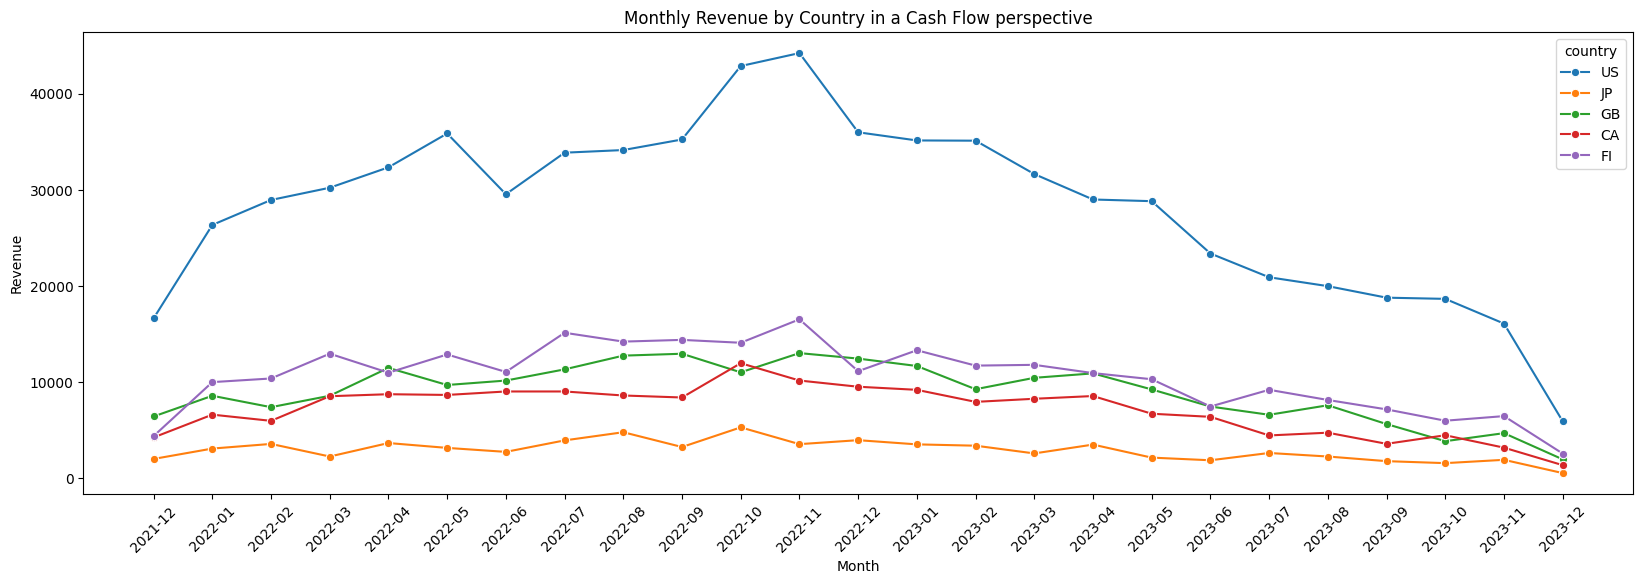

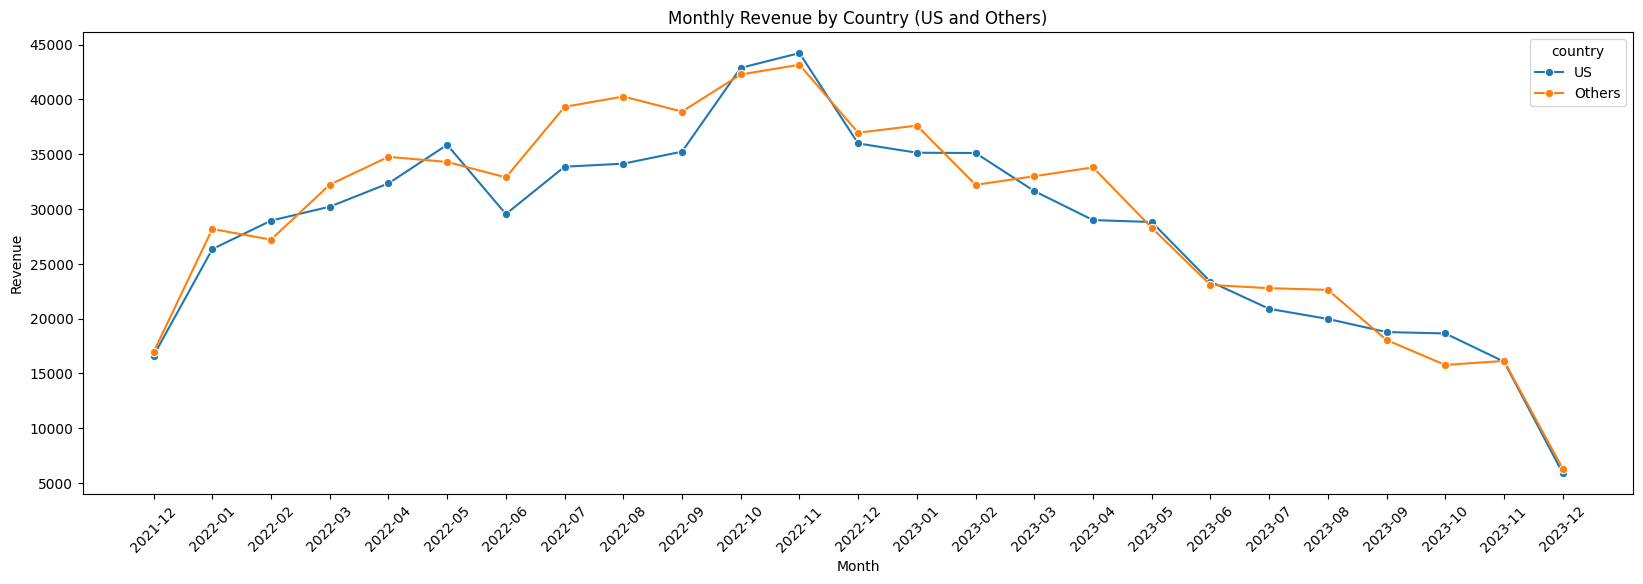

In [13]:
qry = """
    SELECT 
        LEFT(payment_date, 7) AS payment_month
        , subs.country
        , SUM(payment_value) AS revenue
    FROM
        cash_flow_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    GROUP BY
        LEFT(payment_date, 7)
        , subs.country
"""

cashflow_revenue_by_country = duckdb.query(qry).df()
cashflow_revenue_by_country = cashflow_revenue_by_country.sort_values('payment_month', ascending=True)


qry2 = """
    SELECT 
        LEFT(payment_date, 7) AS payment_month
        , CASE WHEN subs.country = 'US' THEN 'US' ELSE 'Others' END AS country
        , SUM(payment_value) AS revenue
    FROM
        cash_flow_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    GROUP BY
        LEFT(payment_date, 7)
        , CASE WHEN subs.country = 'US' THEN 'US' ELSE 'Others' END
"""

cashflow_revenue_by_country_summarized = duckdb.query(qry2).df().sort_values('payment_month', ascending=True)

# ----------- CHART 01
plt.figure(figsize=(20,6))
sns.lineplot(data=cashflow_revenue_by_country, 
             x='payment_month', 
             y='revenue', 
             hue='country', 
             marker='o')

plt.title('Monthly Revenue by Country in a Cash Flow perspective')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)

plt.show()


# ----------- CHART 02
plt.figure(figsize=(20,6))
sns.lineplot(data=cashflow_revenue_by_country_summarized, 
             x='payment_month', 
             y='revenue', 
             hue='country', 
             marker='o')

plt.title('Monthly Revenue by Country (US and Others)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)

plt.show()

The US is where most of the revenue comes from. It is the same as all revenue from the other countries combined, practically.

### Average Ticket

In [28]:
qry = """
    SELECT 
        subs.country
        , payments.subscription_type
        , AVG(payments.payment_value) AS avg_ticket
    FROM
        cash_flow_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    GROUP BY
        subs.country
        , payments.subscription_type
    ORDER BY
        subs.country ASC
        , AVG(payments.payment_value) DESC
"""

avg_ticket_df = duckdb.query(qry).df()

pivot_df = avg_ticket_df.pivot_table(values='avg_ticket', index='country', columns='subscription_type')
pivot_df

subscription_type,Monthly,Yearly
country,,
CA,18.99,132.93
FI,19.99,139.93
GB,21.99,153.93
JP,22.99,160.93
US,24.99,174.93


# Final Answer:


The last month's total revenue by the cashflow was €32,204.70. 

If we look at the data on using accrual basis, where annual revenue amounts are recognized as the customer uses the app, last month's total revenue was €29,278.80.

The customers from US represent virtually 50% of the revenue, but it has the higher average ticket, either the annual or the monthly subscription type.